## 練習時間
參考 Day 12 範例程式，離散化你覺得有興趣的欄位，並嘗試找出有趣的訊息

In [1]:
# Import 需要的套件
import os
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

### 之前做過的處理

In [2]:
# 設定 data_path
dir_data = './data/'
f_app_train = os.path.join(dir_data, 'application_train.csv')
f_app_test = os.path.join(dir_data, 'application_test.csv')

app_train = pd.read_csv(f_app_train)
app_test = pd.read_csv(f_app_test)

from sklearn.preprocessing import LabelEncoder

# Create a label encoder object
le = LabelEncoder()
le_count = 0

# Iterate through the columns
for col in app_train:
    if app_train[col].dtype == 'object':
        # If 2 or fewer unique categories
        if len(list(app_train[col].unique())) <= 2:
            # Train on the training data
            le.fit(app_train[col])
            # Transform both training and testing data
            app_train[col] = le.transform(app_train[col])
            app_test[col] = le.transform(app_test[col])
            
            # Keep track of how many columns were label encoded
            le_count += 1
            
app_train = pd.get_dummies(app_train)
app_test = pd.get_dummies(app_test)

# Create an anomalous flag column
app_train['DAYS_EMPLOYED_ANOM'] = app_train["DAYS_EMPLOYED"] == 365243
app_train['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)
# also apply to testing dataset
app_test['DAYS_EMPLOYED_ANOM'] = app_test["DAYS_EMPLOYED"] == 365243
app_test["DAYS_EMPLOYED"].replace({365243: np.nan}, inplace = True)

# absolute the value of DAYS_BIRTH
app_train['DAYS_BIRTH'] = abs(app_train['DAYS_BIRTH'])
app_test['DAYS_BIRTH'] = abs(app_test['DAYS_BIRTH'])

In [3]:
app_train.DAYS_EMPLOYED.describe()

count    252137.000000
mean      -2384.169325
std        2338.360162
min      -17912.000000
25%       -3175.000000
50%       -1648.000000
75%        -767.000000
max           0.000000
Name: DAYS_EMPLOYED, dtype: float64

In [4]:
app_train['DAYS_EMPLOYED_ANOM'].value_counts()

False    252137
True      55374
Name: DAYS_EMPLOYED_ANOM, dtype: int64

In [5]:
app_train['DAYS_EMPLOYED'].isnull().sum()

55374

In [6]:
app_train['DAYS_EMPLOYED_1'] = abs(app_train['DAYS_EMPLOYED'])

### DAYS_EMPLOYED

#### 級距等寬

In [7]:
app_train['days_employed_equalwidth'] = pd.cut(app_train['DAYS_EMPLOYED_1']/365,20)
app_train['days_employed_equalwidth'].value_counts()

(-0.0491, 2.454]    73738
(2.454, 4.907]      60654
(4.907, 7.361]      38115
(7.361, 9.815]      27073
(9.815, 12.268]     16341
(12.268, 14.722]    11591
(14.722, 17.176]     6680
(17.176, 19.63]      4702
(19.63, 22.083]      3889
(22.083, 24.537]     2674
(24.537, 26.991]     1831
(26.991, 29.444]     1556
(29.444, 31.898]     1129
(31.898, 34.352]      898
(34.352, 36.805]      618
(36.805, 39.259]      337
(39.259, 41.713]      184
(41.713, 44.167]       77
(44.167, 46.62]        43
(46.62, 49.074]         7
Name: days_employed_equalwidth, dtype: int64

Text(0.5,1,'Employed Years of Client')

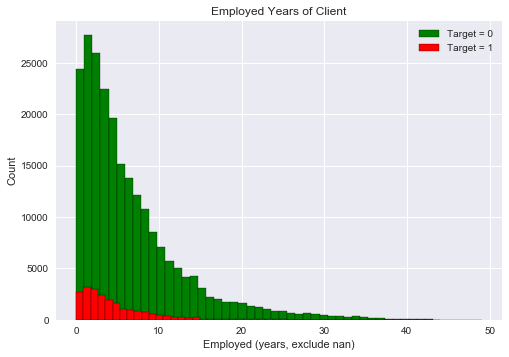

In [8]:
data0 = app_train[(app_train['DAYS_EMPLOYED_1'].notnull() == True) & (app_train['TARGET'] == 0)]['DAYS_EMPLOYED_1'] / 365
data1 = app_train[(app_train['DAYS_EMPLOYED_1'].notnull() == True) & (app_train['TARGET'] == 1)]['DAYS_EMPLOYED_1'] / 365

plt.style.use('seaborn') 

plt.hist(data0, edgecolor = 'k', bins = 50, label = 'Target = 0', color = 'g')
plt.hist(data1, edgecolor = 'k', bins = 50, label = 'Target = 1', color = 'r')

plt.legend()
plt.xlabel('Employed (years, exclude nan)'); plt.ylabel('Count'); plt.title('Employed Years of Client')

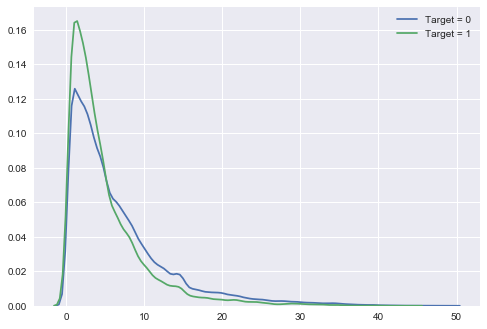

In [9]:
sns.kdeplot(data0, label = 'Target = 0')
sns.kdeplot(data1, label = 'Target = 1')

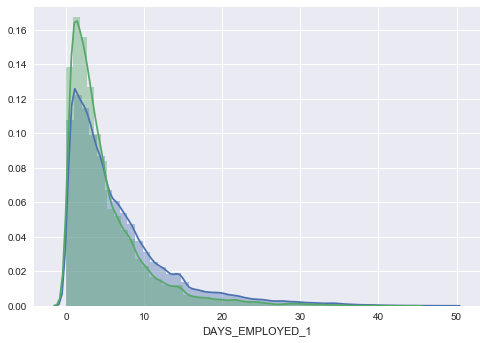

In [10]:
sns.distplot(data0, label = 'Target = 0')
sns.distplot(data1, label = 'Target = 1')

#### 等頻劃分

In [11]:
app_train['days_employed_equalwidth'] = pd.qcut(app_train['DAYS_EMPLOYED_1']/365,20)
app_train['days_employed_equalwidth'].value_counts().sort_index()

(-0.001, 0.564]     12669
(0.564, 0.912]      12566
(0.912, 1.282]      12652
(1.282, 1.69]       12624
(1.69, 2.101]       12545
(2.101, 2.518]      12614
(2.518, 2.959]      12667
(2.959, 3.425]      12583
(3.425, 3.953]      12579
(3.953, 4.515]      12625
(4.515, 5.126]      12567
(5.126, 5.918]      12619
(5.918, 6.732]      12602
(6.732, 7.649]      12604
(7.649, 8.699]      12588
(8.699, 10.071]     12605
(10.071, 11.978]    12612
(11.978, 14.611]    12605
(14.611, 19.975]    12605
(19.975, 49.074]    12606
Name: days_employed_equalwidth, dtype: int64

#### 自行定義

In [12]:
employed_g = pd.DataFrame({'employed': [0, 5, 10, 15, 20, 30, 40, 50]})

app_train['employed_g'] = pd.cut(app_train['DAYS_EMPLOYED_1']/365, employed_g['employed'])

app_train['employed_g'].value_counts().sort_index()

(0, 5]      136309
(5, 10]      64872
(10, 15]     27549
(15, 20]     10849
(20, 30]      9551
(30, 40]      2771
(40, 50]       234
Name: employed_g, dtype: int64

### DAYS_REGISTRATION

In [13]:
app_train['DAYS_REGISTRATION'].describe()

count    307511.000000
mean      -4986.120328
std        3522.886321
min      -24672.000000
25%       -7479.500000
50%       -4504.000000
75%       -2010.000000
max           0.000000
Name: DAYS_REGISTRATION, dtype: float64

In [14]:
app_train['DAYS_REGISTRATION'].isnull().sum()

0

In [15]:
app_train['DAYS_REGISTRATION_1'] = abs(app_train['DAYS_REGISTRATION'])

Text(0.5,1,'Registration Years of Client')

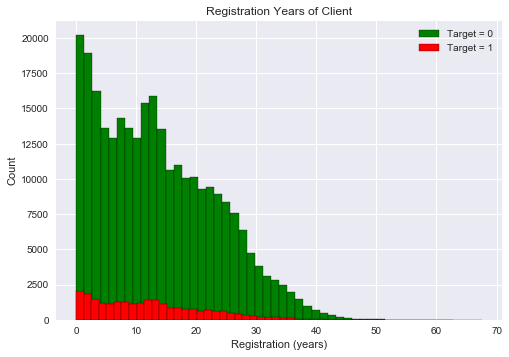

In [16]:
data0 = app_train[app_train['TARGET'] == 0]['DAYS_REGISTRATION_1'] / 365
data1 = app_train[app_train['TARGET'] == 1]['DAYS_REGISTRATION_1'] / 365

plt.style.use('seaborn') 

plt.hist(data0, edgecolor = 'k', bins = 50, label = 'Target = 0', color = 'g')
plt.hist(data1, edgecolor = 'k', bins = 50, label = 'Target = 1', color = 'r')

plt.legend()
plt.xlabel('Registration (years)'); plt.ylabel('Count'); plt.title('Registration Years of Client')

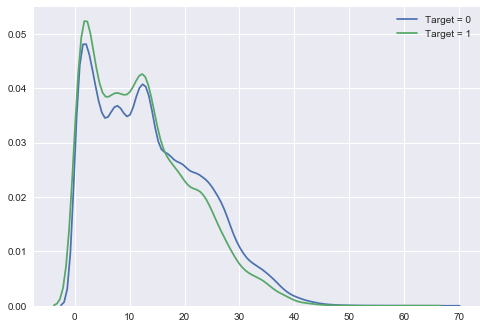

In [17]:
sns.kdeplot(data0, label = 'Target = 0')
sns.kdeplot(data1, label = 'Target = 1')

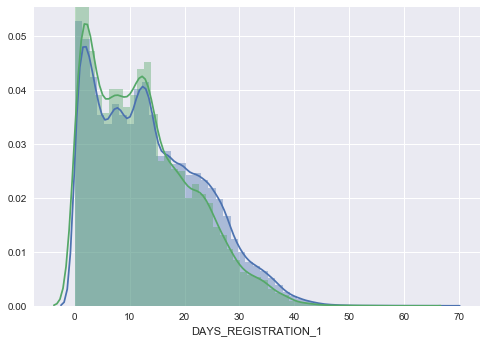

In [18]:
sns.distplot(data0, label = 'Target = 0')
sns.distplot(data1, label = 'Target = 1')

### OWN_CAR_AGE

In [19]:
app_train['OWN_CAR_AGE'].describe()

count    104582.000000
mean         12.061091
std          11.944812
min           0.000000
25%           5.000000
50%           9.000000
75%          15.000000
max          91.000000
Name: OWN_CAR_AGE, dtype: float64

In [20]:
app_train['OWN_CAR_AGE'].isnull().sum()

202929

Text(0.5,1,'Own Car Age of Client')

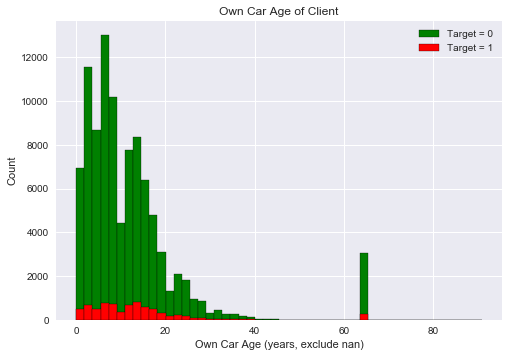

In [21]:
data0 = app_train[(app_train['OWN_CAR_AGE'].notnull() == True) & (app_train['TARGET'] == 0)]['OWN_CAR_AGE'] 
data1 = app_train[(app_train['OWN_CAR_AGE'].notnull() == True) & (app_train['TARGET'] == 1)]['OWN_CAR_AGE'] 

plt.style.use('seaborn') 

plt.hist(data0, edgecolor = 'k', bins = 50, label = 'Target = 0', color = 'g')
plt.hist(data1, edgecolor = 'k', bins = 50, label = 'Target = 1', color = 'r')

plt.legend()
plt.xlabel('Own Car Age (years, exclude nan)'); plt.ylabel('Count'); plt.title('Own Car Age of Client')

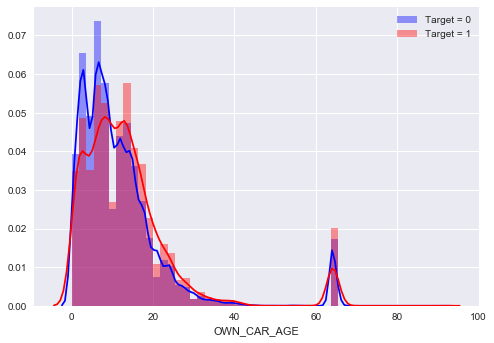

In [22]:
sns.distplot(data0, label = 'Target = 0', color = 'b')
sns.distplot(data1, label = 'Target = 1', color = 'r')
plt.legend()

### EXT_SOURCE_1 ~  EXT_SOURCE_3

In [23]:
pd.options.display.float_format = '{:.6f}'.format

print('=======EXT_SOURCE_1=======')
print(app_train['EXT_SOURCE_1'].describe())
print('')

print('=======EXT_SOURCE_1=======')
print(app_train['EXT_SOURCE_2'].describe())
print('')

print('=======EXT_SOURCE_1=======')
print(app_train['EXT_SOURCE_3'].describe())

=======EXT_SOURCE_1=======
count   134133.000000
mean         0.502130
std          0.211062
min          0.014568
25%          0.334007
50%          0.505998
75%          0.675053
max          0.962693
Name: EXT_SOURCE_1, dtype: float64

=======EXT_SOURCE_1=======
count   306851.000000
mean         0.514393
std          0.191060
min          0.000000
25%          0.392457
50%          0.565961
75%          0.663617
max          0.855000
Name: EXT_SOURCE_2, dtype: float64

=======EXT_SOURCE_1=======
count   246546.000000
mean         0.510853
std          0.194844
min          0.000527
25%          0.370650
50%          0.535276
75%          0.669057
max          0.896010
Name: EXT_SOURCE_3, dtype: float64


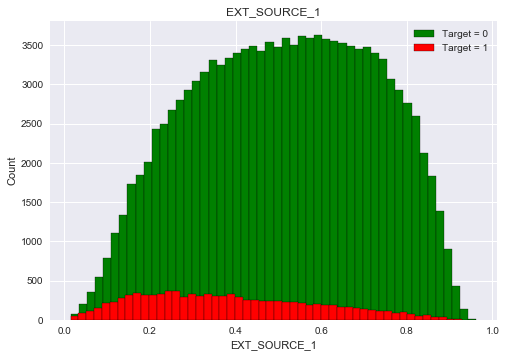

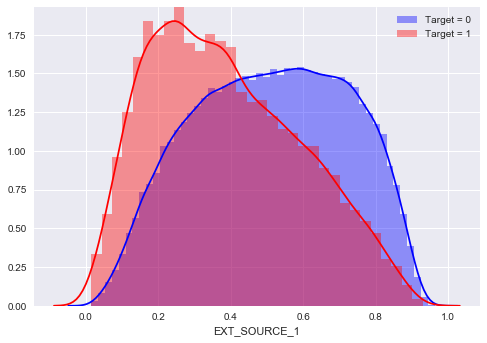

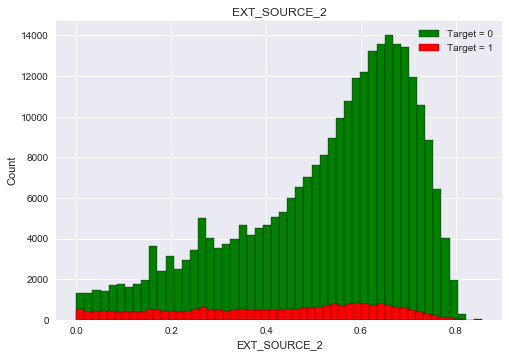

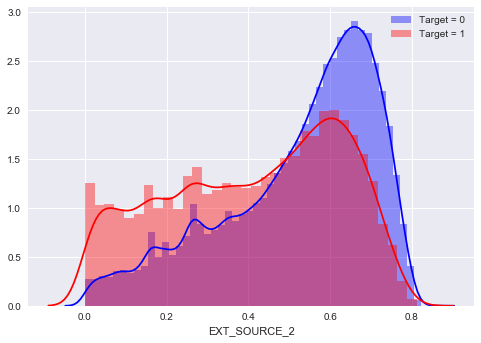

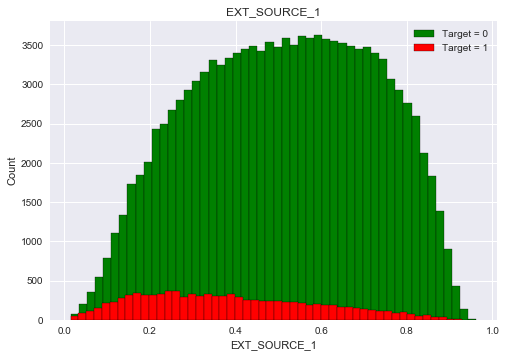

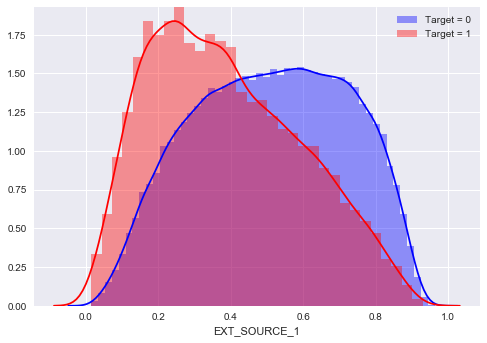

In [24]:
cols = ['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_1']

for col in cols:
    
    data0 = app_train[(app_train[col].notnull() == True) & (app_train['TARGET'] == 0)][col] 
    data1 = app_train[(app_train[col].notnull() == True) & (app_train['TARGET'] == 1)][col] 

    plt.style.use('seaborn') 

    plt.hist(data0, edgecolor = 'k', bins = 50, label = 'Target = 0', color = 'g')
    plt.hist(data1, edgecolor = 'k', bins = 50, label = 'Target = 1', color = 'r')

    plt.legend()
    plt.xlabel(col); plt.ylabel('Count'); plt.title(col)
    plt.show()
    
    sns.distplot(data0, label = 'Target = 0', color = 'b')
    sns.distplot(data1, label = 'Target = 1', color = 'r')
    plt.legend()
    
    plt.show()